In [1]:
import bioframe as bf
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
from gpn.data import Genome

enformer = pd.read_parquet("../../results/enformer/merged.parquet")
genome = Genome("../../results/genome.fa.gz")
enformer["ref_nuc"] = enformer.progress_apply(lambda v: genome.get_nuc(v.chrom, v.pos).upper(), axis=1)
mask = enformer['ref'] != enformer['ref_nuc']
enformer.loc[mask, ['ref', 'alt']] = enformer.loc[mask, ['alt', 'ref']].values
enformer.to_parquet("../../results/enformer/merged.correct_ref_alt.parquet", index=False)
""";

In [3]:
# TODO: in the future can split train/val and test according to even/odd
# and just do 2 splits
TRAIN_CHROMS = [str(i) for i in range(1, 11)]
VALIDATION_CHROMS = ["11", "12"]
D = 768

In [4]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = load_dataset("../../results/gtex/merged", split="test").to_pandas()
d = Path(f"../../results/preds/results/gtex/merged")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,1,14677,G,A,True,-0.370660,-0.452,-0.000,-1.902,-1.095050
1,1,17730,C,A,False,-1.218470,-2.889,-1.000,-4.690,1.481261
2,1,54490,G,A,True,0.201295,0.313,-0.000,-0.029,0.039775
3,1,63671,G,A,True,-0.344458,1.392,-0.000,-0.253,3.129621
4,1,63697,T,C,True,-1.180623,-1.155,-0.701,-2.212,-6.382286
...,...,...,...,...,...,...,...,...,...,...
58405,X,155744353,G,T,True,0.158726,0.107,-0.001,-1.722,-0.079454
58406,X,155768650,G,T,True,-1.179355,-2.212,-1.000,-2.759,7.381042
58407,X,155768714,G,C,True,-0.088585,0.175,-0.640,-0.502,-3.618934
58408,X,155779999,A,C,False,0.076083,0.156,-0.000,0.200,-1.525492


In [5]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/results/gtex/merged/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,1,14677,G,A,True,-0.370660,-0.452,-0.000,-1.902,-1.095050,...,89.838196,199.672211,77.431107,118.214149,76.438446,85.780685,116.801186,134.992523,98.798294,136.315735
1,1,17730,C,A,False,-1.218470,-2.889,-1.000,-4.690,1.481261,...,89.713486,146.122437,71.958832,127.378113,105.690369,146.376953,127.883156,86.037689,110.304382,148.695740
2,1,54490,G,A,True,0.201295,0.313,-0.000,-0.029,0.039775,...,78.218887,195.490768,65.736748,116.196938,37.669392,61.344448,66.525375,222.361511,86.355278,123.404312
3,1,63671,G,A,True,-0.344458,1.392,-0.000,-0.253,3.129621,...,60.808266,185.885147,56.572441,108.371582,48.275101,132.780823,117.328644,145.440216,78.304321,113.809845
4,1,63697,T,C,True,-1.180623,-1.155,-0.701,-2.212,-6.382286,...,54.700588,199.266296,62.107849,108.522766,44.507469,128.121628,97.487602,157.041504,88.587296,103.449051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58405,X,155744353,G,T,True,0.158726,0.107,-0.001,-1.722,-0.079454,...,57.104858,176.774933,72.009583,111.837677,52.309387,86.697060,71.960938,207.810165,105.583748,117.820549
58406,X,155768650,G,T,True,-1.179355,-2.212,-1.000,-2.759,7.381042,...,108.762115,68.121475,72.987350,104.171677,60.890697,148.558319,88.829399,97.425491,92.073380,120.274269
58407,X,155768714,G,C,True,-0.088585,0.175,-0.640,-0.502,-3.618934,...,102.985809,61.088684,77.131180,94.744843,62.962914,159.890121,122.761765,98.166855,117.757278,98.256119
58408,X,155779999,A,C,False,0.076083,0.156,-0.000,0.200,-1.525492,...,51.425179,167.560028,70.923637,137.495300,67.493050,99.918846,77.596214,244.060669,113.120598,108.227631


In [6]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [7]:
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
cols = ["chrom", "pos", "ref", "alt"]
V = V.merge(enformer, on=cols, how="inner")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V

,chrom,pos,ref,alt,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,...,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,54490,G,A,True,0.201295,0.313,-0.000,-0.029,-0.039775,...,37.669392,61.344448,66.525375,222.361511,86.355278,123.404312,-1.388672,-0.039154,-0.008972,G
1,1,63671,G,A,True,-0.344458,1.392,-0.000,-0.253,-3.129621,...,48.275101,132.780823,117.328644,145.440216,78.304321,113.809845,-5.425781,-0.119751,-0.015160,G
2,1,108230,C,T,True,-0.244932,0.480,-0.000,-0.118,-0.162981,...,59.881935,62.677105,35.060310,262.469727,128.727829,109.150986,-2.343750,-0.045624,-0.005436,C
3,1,135203,G,A,True,-0.183566,0.239,-0.000,0.338,-0.981487,...,40.877106,85.952293,51.371506,79.543945,43.016586,80.492035,-1.589844,-0.028915,-0.002449,G
4,1,263722,C,G,True,0.263589,2.308,-0.000,-0.586,-0.079175,...,85.976074,122.279617,222.493393,243.337738,242.634705,86.137978,-6.570312,-0.160400,-0.069763,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54393,9,138175111,A,G,False,-0.447451,-0.243,-0.180,1.593,-3.140078,...,63.530533,140.270294,96.961868,126.968872,82.814278,165.155060,-6.011719,-0.129883,-0.029022,A
54394,9,138181974,A,C,False,-0.365930,-0.221,-0.117,1.223,-2.610379,...,79.882507,91.263206,320.788513,345.249512,153.408325,70.301895,-2.466797,-0.046692,-0.006752,A
54395,9,138198178,A,C,False,-0.149840,1.131,-0.053,3.364,-0.731493,...,79.665512,83.797180,303.865906,331.087219,157.133484,69.321274,-3.267578,-0.065796,-0.008209,A
54396,9,138210807,T,A,True,0.009917,0.967,-0.000,0.336,-1.311008,...,59.335842,86.866348,69.095901,237.547241,73.296249,71.876511,-9.937500,-0.290283,-0.111389,T


In [8]:
V_train = V[V.chrom.isin(TRAIN_CHROMS)].copy()
V_validation = V[V.chrom.isin(VALIDATION_CHROMS)].copy()
V_test = V[(~V.chrom.isin(TRAIN_CHROMS)) & (~V.chrom.isin(VALIDATION_CHROMS))].copy()
len(V_train), len(V_validation), len(V_test)

(27804, 2485, 24109)

In [9]:
results_train = pd.DataFrame([
    [f"embedding_{i}", average_precision_score(V_train.label, -V_train[f"embedding_{i}"])]
    for i in tqdm(range(D))
], columns=["Model", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_train

100%|██████████| 768/768 [00:04<00:00, 186.67it/s]


,Model,AUPRC
112,embedding_112,0.486988
761,embedding_761,0.485115
501,embedding_501,0.481255
39,embedding_39,0.481202
457,embedding_457,0.474064
...,...,...
402,embedding_402,0.227796
608,embedding_608,0.226087
381,embedding_381,0.225017
173,embedding_173,0.224792


In [10]:
sorted_indices = results_train.Model.values
sorted_indices[:10]

array(['embedding_112', 'embedding_761', 'embedding_501', 'embedding_39',
       'embedding_457', 'embedding_243', 'embedding_661', 'embedding_276',
       'embedding_132', 'embedding_481'], dtype=object)

In [11]:
V_test["inner_product_select_dimensions"] = V_test[sorted_indices[:10]].sum(axis=1)
models.append("inner_product_select_dimensions")

In [12]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V_test.dropna(subset=models)
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    AUPRC = average_precision_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC, AUPRC])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results

100%|██████████| 7/7 [00:00<00:00, 83.76it/s]


,Model,AUROC,AUPRC
0,CADD,0.552221,0.392787
1,phyloP-100-vertebrates,0.525723,0.347827
2,phastCons-100-vertebrates,0.474219,0.330502
3,phyloP-241-mammals,0.530219,0.368644
4,GPN-MSA,0.548426,0.373345
5,Enformer_l2,0.689309,0.560447
6,inner_product_select_dimensions,0.666616,0.499504


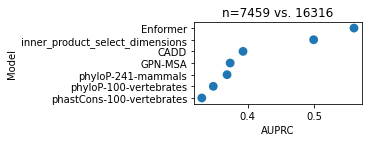

In [13]:
plt.figure(figsize=(3,1.5))
sns.pointplot(
    data=results.sort_values("AUPRC", ascending=False).replace("Enformer_l2", "Enformer"),
    y="Model",
    x="AUPRC",
    join=False,
)
plt.title(subtitle);

## Training a layer on top

In [14]:
# TODO: try without freezing!
# TODO: start with fwd strand only (at test time), then average both
# TODO: make sure this works for both GPN and GPN-MSA
# TODO: potentially add loss weight = inverse square prop or similar (accepted by BCEWithLogitsLoss)

In [83]:
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from transformers import (
    AutoConfig,
    AutoModel,
    PretrainedConfig,
    PreTrainedModel,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.activations import ACT2FN
from transformers.modeling_outputs import (
    BaseModelOutput,
    MaskedLMOutput,
    SequenceClassifierOutput,
)
from gpn.data import Tokenizer, ReverseComplementer
from gpn.model import GPNRoFormerPreTrainedModel, GPNRoFormerModel

"""
class GPNRoformerForAffectTrait(GPNRoFormerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.model = GPNRoFormerModel(config)
        self.linear1 = nn.Linear(config.hidden_size, config.affect_trait_dim)
        self.linear2 = nn.Linear(1, 1)

        # Initialize weights and apply final processing
        self.post_init()
        
    def embed_seq(self, input_ids=None, aux_features=None):
        x = self.model(input_ids=input_ids, aux_features=aux_features).last_hidden_state
        return self.linear1(x)

    def forward(
        self,
        input_ids_ref=None, aux_features_ref=None,
        input_ids_alt=None, aux_features_alt=None,
        labels=None,
    ):
        embedding_ref = self.embed_seq(
            input_ids=input_ids_ref, aux_features=aux_features_ref,
        )
        embedding_alt = self.embed_seq(
            input_ids=input_ids_alt, aux_features=aux_features_alt,
        )
        minus_dot_product = -(embedding_ref * embedding_alt).sum(dim=(1,2)).unsqueeze(1)
        logits = self.linear2(minus_dot_product).squeeze()

        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )
"""

"""
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomLinear, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))

        # Initialize weights and bias
        nn.init.normal_(self.weights, mean=np.log(1/in_featuresZ), std=0.02)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        weights_normalized = torch.exp(self.weights)
        print(f"{weights_normalized=}")
        return F.linear(x, weights_normalized, self.bias)
"""


class GPNRoformerForAffectTrait(GPNRoFormerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.model = GPNRoFormerModel(config)
        self.linear = nn.Linear(config.hidden_size, 1)

        # Initialize weights and apply final processing
        self.post_init()
        
    def embed_seq(self, input_ids=None, aux_features=None):
        return self.model(input_ids=input_ids, aux_features=aux_features).last_hidden_state

    def forward(
        self,
        input_ids_ref=None, aux_features_ref=None,
        input_ids_alt=None, aux_features_alt=None,
        labels=None,
    ):
        embedding_ref = self.embed_seq(
            input_ids=input_ids_ref, aux_features=aux_features_ref,
        )
        embedding_alt = self.embed_seq(
            input_ids=input_ids_alt, aux_features=aux_features_alt,
        )
        # TODO: should enforce positivity by using F.linear or something
        minus_dot_product = -(embedding_ref * embedding_alt).sum(dim=1)
        print(f"{minus_dot_product=}")
        print(f"{minus_dot_product.shape=}")
        logits = self.linear(minus_dot_product).squeeze()
        print(f"{logits=}")
        print(f"{logits.shape=}")
        raise Exception("debug")
        
        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )


class DataProvider(object):
    def __init__(self, genome_msa, window_size):
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        #print(V)
        #raise Exception("debug")
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        #(
        #    res["input_ids_ref_fwd"],
        #    res["aux_features_ref_fwd"],
        #    res["input_ids_alt_fwd"],
        #    res["aux_features_alt_fwd"],
        #) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        #(
        #    res["input_ids_ref_rev"],
        #    res["aux_features_ref_rev"],
        #    res["input_ids_alt_rev"],
        #    res["aux_features_alt_rev"],
        #) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        
        (
            res["input_ids_ref"],
            res["aux_features_ref"],
            res["input_ids_alt"],
            res["aux_features_alt"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        if "label" in V:
            res["labels"] = V["label"]
        return res

In [84]:
from gpn.data import GenomeMSA

genome_msa = GenomeMSA("../../results/msa/multiz100way/89/all.zarr")
data_provider = DataProvider(genome_msa, 128)

Loading MSA...
Loading MSA... Done


In [85]:
from datasets import Dataset

def my_load_dataset(V):
    dataset = V[cols + ["label"]].copy()
    dataset.label = dataset.label.astype(float)
    dataset = Dataset.from_pandas(dataset)
    dataset.set_transform(data_provider.tokenize_function)
    return dataset

In [86]:
def train_and_test():
    seed = 42
    set_seed(seed)
    
    config = AutoConfig.from_pretrained("songlab/gpn-msa-sapiens")
    #config.affect_trait_dim = 64
    model = GPNRoformerForAffectTrait.from_pretrained("songlab/gpn-msa-sapiens", config=config)
    for param in model.model.parameters(): param.requires_grad = False  # freeze the encoder

    train_dataset = my_load_dataset(V_train).shuffle(seed=42)
    validation_dataset = my_load_dataset(V_validation)
    test_dataset = my_load_dataset(V_test)

    training_args = TrainingArguments(
        output_dir=tempfile.TemporaryDirectory().name,
        per_device_train_batch_size=256,
        per_device_eval_batch_size=4096,
        gradient_accumulation_steps=1,
        dataloader_num_workers=8,
        fp16=True,
        weight_decay=0.01,
        optim="adamw_torch",
        seed=seed,
        save_strategy="epoch",
        save_total_limit=1,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=10,
        warmup_ratio=0.01,
        lr_scheduler_type="cosine",
        learning_rate=1e-4,
        remove_unused_columns=False,
        report_to="none",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
    )
    # could try wandb sweep for hparams (random search)
    trainer.train()
    test_output = trainer.predict(test_dataset=test_dataset).predictions
    return test_output

In [87]:
V_test["layer_on_top"] = -train_and_test()
if "layer_on_top" not in models: models.append("layer_on_top")

Some weights of GPNRoformerForAffectTrait were not initialized from the model checkpoint at songlab/gpn-msa-sapiens and are newly initialized: ['linear.weight', 'linear.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


minus_dot_product=tensor([[ -60.6983, -254.6215, -394.4081,  ..., -202.8857, -138.6718,
          -87.7185],
        [ -49.5687, -142.1396, -357.7785,  ..., -261.0012,  -75.3636,
         -125.9182],
        [-276.4459, -208.6881, -310.6472,  ..., -204.5766, -171.9836,
          -63.6281],
        ...,
        [ -41.0637,  -74.5628, -334.7136,  ..., -285.5878, -107.0852,
         -133.8367],
        [-246.7644, -145.7773, -307.3300,  ..., -239.6556,  -62.3692,
          -67.5684],
        [ -56.8814,  -68.4629, -282.0012,  ..., -211.7873,  -72.5903,
         -155.8084]], device='cuda:0')
minus_dot_product.shape=torch.Size([256, 768])
logits=tensor([-12.5859,  -4.9531,  56.3750, -24.1094,   0.6616,  -1.5615, -10.8125,
         63.0312, -26.8125, -31.0000, -49.5938, -29.1875, -30.9062, -30.7656,
        -20.0625, -12.8047, -24.1250, -19.0469, -25.4219,  56.8750, -20.7812,
        -25.5000,   3.6465, -24.8594,  -5.6758, -27.5156, -17.2031, -31.4844,
        -16.8750, -28.0938,  -8.5703,  

Exception: debug

In [92]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = [f"embedding_{i}" for i in range(D)]

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LogisticRegressionCV(
        random_state=42,
        class_weight="balanced",
        scoring="average_precision",
        #Cs=np.logspace(-5, -3, 10),
        n_jobs=8,
        max_iter=1000,
    ))
])

clf.fit(V_train[features], V_train.label)
pred = -clf.predict_proba(V_test[features])[:, 1]
V_test["inner_product_logistic_regression"] = pred
if "inner_product_logistic_regression" not in models: models.append("inner_product_logistic_regression")

In [97]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V_test.dropna(subset=models)
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    AUPRC = average_precision_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC, AUPRC])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results

100%|██████████| 9/9 [00:00<00:00, 85.34it/s]


,Model,AUROC,AUPRC
0,CADD,0.552221,0.392787
1,phyloP-100-vertebrates,0.525723,0.347827
2,phastCons-100-vertebrates,0.474219,0.330502
3,phyloP-241-mammals,0.530219,0.368644
4,GPN-MSA,0.548426,0.373345
5,Enformer_l2,0.689309,0.560447
6,inner_product_select_dimensions,0.666616,0.499504
7,layer_on_top,0.583344,0.400157
8,inner_product_logistic_regression,0.684591,0.514682


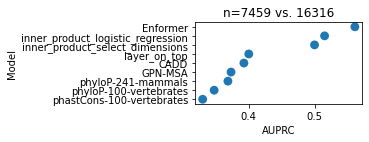

In [98]:
plt.figure(figsize=(3,1.5))
sns.pointplot(
    data=results.sort_values("AUPRC", ascending=False).replace("Enformer_l2", "Enformer"),
    y="Model",
    x="AUPRC",
    join=False,
)
plt.title(subtitle);